In [1]:
# Description: This program uses Fibonaci retracement levels and MACD to indicate when to buy and sell a stock

In [2]:
#Import the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [3]:
import yfinance as yf
df = yf.download('AAPL', start='2017-04-20', end='2017-08-25')

[*********************100%***********************]  1 of 1 completed


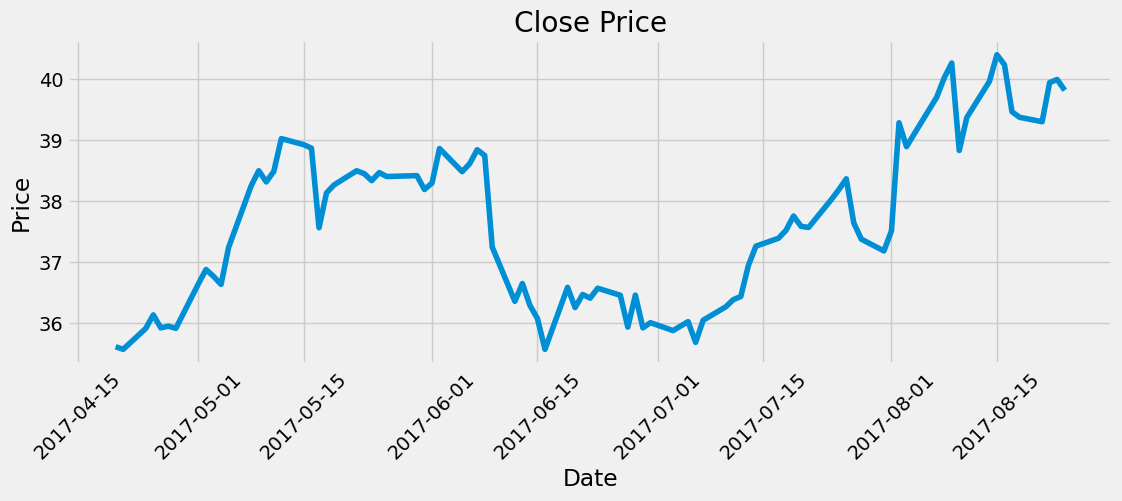

In [4]:
#plot the data
plt.figure(figsize=(12,4))
plt.plot(df.Close)
plt.title('Close Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.xticks(rotation=45)
plt.show()

In [5]:
#Calculate the Fibonacci Retracement Levels
max_price= df['Close'].max()
min_price= df['Close'].min()

difference=max_price-min_price
first_level= max_price -difference*0.236
second_level= max_price -difference*0.382
third_level= max_price -difference*0.5
fourth_level= max_price -difference*0.618


In [6]:
#Calculate the MACD line and the Signal Line Indicators
#Calculate the Short Term Exponential Moving Average
ShortEMA= df.Close.ewm(span=12,adjust=False).mean()
#Calculate the Long Term Exponential Moving Average
LongEMA=df.Close.ewm(span=26,adjust=False).mean()
#Calculate the Moving Average Convergence/Divergence (MACD)
MACD= ShortEMA- LongEMA
#Calculate the Signal Line
signal= MACD.ewm(span=9,adjust=False).mean()

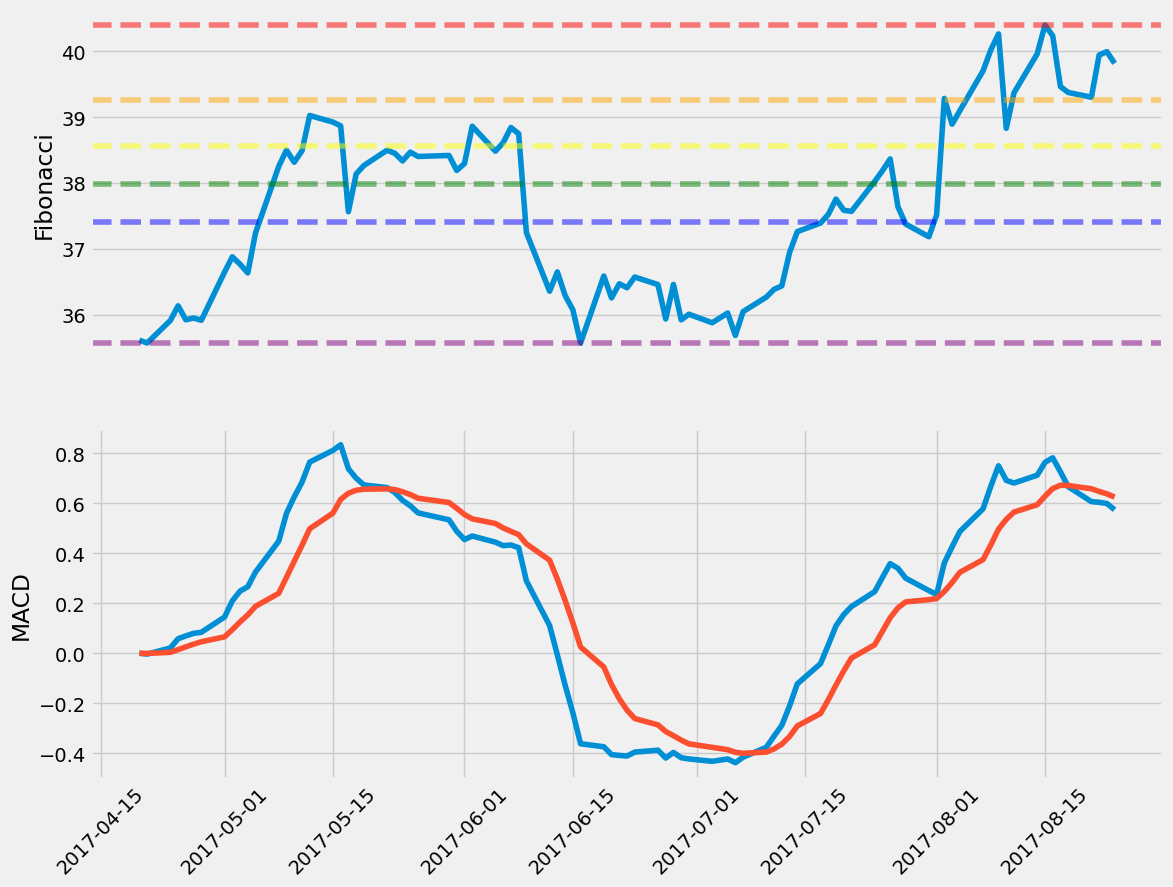

In [7]:
#Plot the Fibonacci Levels along with the close price and the MACD and Signal Line
new_df= df

#plot the Fibonacci Levels
plt.figure(figsize=(12.33,9.5))
plt.subplot(2,1,1)
plt.plot(new_df.index,new_df['Close'])
plt.axhline(max_price,linestyle='--',alpha=0.5,color='red')
plt.axhline(first_level,linestyle='--',alpha=0.5,color='orange')
plt.axhline(second_level,linestyle='--',alpha=0.5,color='yellow')
plt.axhline(third_level,linestyle='--',alpha=0.5,color='green')
plt.axhline(fourth_level,linestyle='--',alpha=0.5,color='blue')
plt.axhline(min_price,linestyle='--',alpha=0.5,color='purple')
plt.ylabel('Fibonacci')
frame1=plt.gca()
frame1.axes.get_xaxis().set_visible(False)

#Plot the MACD line and the Signal Line
plt.subplot(2,1,2)
plt.plot(new_df.index, MACD)
plt.plot(new_df.index, signal)
plt.ylabel('MACD')
plt.xticks(rotation=45)

plt.savefig('Fig1.png')

In [8]:
#Create new columns for the data frame
df['MACD'] = MACD
df['Signal Line']= signal
#Show the new data
df

,Open,High,Low,Close,Adj Close,Volume,MACD,Signal Line
Date,,,,,,,,
2017-04-20,35.305000,35.730000,35.290001,35.610001,33.372929,93278400,0.000000,0.000000
2017-04-21,35.610001,35.669998,35.462502,35.567501,33.333103,69283600,-0.003390,-0.000678
2017-04-24,35.875000,35.987499,35.794998,35.910000,33.654087,68537200,0.021314,0.003720
2017-04-25,35.977501,36.224998,35.967499,36.132500,33.862610,75486000,0.058176,0.014611
2017-04-26,36.117500,36.150002,35.845001,35.919998,33.663448,80164800,0.069441,0.025577
...,...,...,...,...,...,...,...,...
2017-08-18,39.465000,39.875000,39.180000,39.375000,37.199230,109712400,0.666326,0.670928
2017-08-21,39.375000,39.472500,38.777500,39.302502,37.130733,105474000,0.606431,0.658028
2017-08-22,39.557499,40.000000,39.505001,39.945000,37.737740,86418400,0.603847,0.647192


In [9]:
#create a function to be used in our strategy to get the upper Fibonacci level and lower Fibonacci level of the current price
def getLevels(price):
  if price >= first_level:
    return (max_price, first_level)
  elif price>= second_level:
    return (first_level,second_level )
  elif price>= third_level:
    return (second_level,third_level )
  elif price>= fourth_level:
    return (third_level,fourth_level )
  else:
    return (fourth_level, min_price)


In [11]:
#create a function for the trading strategy

#The Strategy
#When the signal line croses above the MACD Line and the current price crossed above or below the last Fibonacci level then buy
#When the signal line croses below the mACD Line and the current price crossed above or below the last Fibonacci level then buy
#Never sell at a price thats lower than I bought

def strategy(df):
  buy_list=[]
  sell_list=[]
  flag=0
  last_buy_price=0

  #loop through the dataset
  for i in range(0, df.shape[0]):
    price=df['Close'][i]
    #if this is the first data within the data set , then get the level above or below it
    if i==0:
      upper_lvl, lower_lvl= getLevels(price)
      buy_list.append(np.nan)
      sell_list.append(np.nan)
    #else if the current price is gretaer than or equal to the lower_lvl,then we know the price has 'hit' or crosses a new Fibonacci level
    elif price>=upper_lvl or price <= lower_lvl:
       #Check to see if the MACD line crossed above or below the signal line
       if df['Signal Line'][i] > df['MACD'][i] and flag==0:
         last_buy_price=price
         buy_list.append(price)
         sell_list.append(np.nan)
         #Set the flag to 1 to signal that share was bought
         flag=1
       elif df['Signal Line'][i] < df['MACD'][i] and flag==1 and price>= last_buy_price:
        buy_list.append(np.nan)
        sell_list.append(price)
        #Set the flag to 0 to signal that share was sold
        flag=0
       else:
          buy_list.append(np.nan)
          sell_list.append(np.nan)

    else:
        buy_list.append(np.nan)
        sell_list.append(np.nan)

    #Update the new levels
    upper_lvl, lower_lvl = getLevels(price)

  return buy_list, sell_list


In [13]:
# Create buy and sell columns
buy, sell= strategy(df)
df['Buy_Signal_Price'] = buy
df['Sell_Signal_Price'] = sell
#Show the data
df

,Open,High,Low,Close,Adj Close,Volume,MACD,Signal Line,Buy_Signal_Price,Sell_Signal_Price
Date,,,,,,,,,,
2017-04-20,35.305000,35.730000,35.290001,35.610001,33.372929,93278400,0.000000,0.000000,NaN,NaN
2017-04-21,35.610001,35.669998,35.462502,35.567501,33.333103,69283600,-0.003390,-0.000678,35.567501,NaN
2017-04-24,35.875000,35.987499,35.794998,35.910000,33.654087,68537200,0.021314,0.003720,NaN,NaN
2017-04-25,35.977501,36.224998,35.967499,36.132500,33.862610,75486000,0.058176,0.014611,NaN,NaN
2017-04-26,36.117500,36.150002,35.845001,35.919998,33.663448,80164800,0.069441,0.025577,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2017-08-18,39.465000,39.875000,39.180000,39.375000,37.199230,109712400,0.666326,0.670928,NaN,NaN
2017-08-21,39.375000,39.472500,38.777500,39.302502,37.130733,105474000,0.606431,0.658028,NaN,NaN
2017-08-22,39.557499,40.000000,39.505001,39.945000,37.737740,86418400,0.603847,0.647192,NaN,NaN


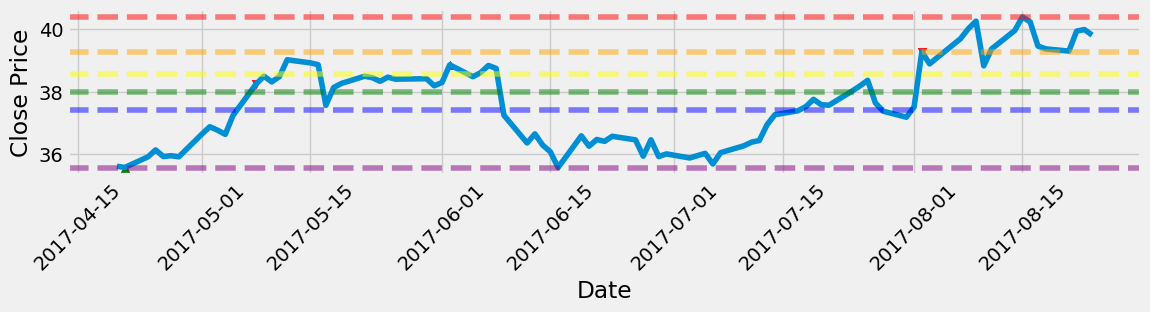

In [15]:
#Plot the Fibonacci levels along with the close price and with the Buy and Sell signals
#Plot the Fibonacci Levels along with the close price and the MACD and Signal Line
new_df= df

#plot the Fibonacci Levels
plt.figure(figsize=(12.33,4.5))
plt.subplot(2,1,1)
plt.plot(new_df.index,new_df['Close'],alpha=0.5)
plt.scatter(new_df.index, new_df['Buy_Signal_Price'],color= 'green', marker= '^', alpha=1)
plt.scatter(new_df.index, new_df['Sell_Signal_Price'], color='red', marker='v', alpha=1)
plt.axhline(max_price,linestyle='--',alpha=0.5,color='red')
plt.axhline(first_level,linestyle='--',alpha=0.5,color='orange')
plt.axhline(second_level,linestyle='--',alpha=0.5,color='yellow')
plt.axhline(third_level,linestyle='--',alpha=0.5,color='green')
plt.axhline(fourth_level,linestyle='--',alpha=0.5,color='blue')
plt.axhline(min_price,linestyle='--',alpha=0.5,color='purple')
plt.ylabel('Close Price')
plt.xlabel('Date')
frame1=plt.gca()
plt.xticks(rotation=45)
plt.show()
